# Multioutput Gaussian Processes in GPflow

This notebook shows how to construct a multi-output GP model using GPflow. We will consider a regression problem for functions $f: \mathbb{R}^D \rightarrow \mathbb{R}^P$. We assume that the dataset is of the form $(X, f_1), \dots, (X, f_P)$, that is, we observe all the outputs for a particular input location (for cases where there are **not** fully observed outputs for each input, see [A simple demonstration of coregionalisation](./coregionalisation.ipynb)).

Here we assume a model of the form: 
$$f(x) = W g(x),$$
where $g(x) \in \mathbb{R}^L$, $f(x) \in \mathbb{R}^P$ and $W \in \mathbb{R}^{P \times L}$. We assume that the outputs of $g$ are uncorrelated, and that by *mixing* them with $W$ they become correlated. In this notebook, we show how to build this model using Sparse Variational Gaussian Process (SVGP) for $g$, which scales well with the numbers of data points and outputs. 

Here we have two options for $g$:
1. The output dimensions of $g$ share the same kernel.
2. Each output of $g$ has a separate kernel.


In addition, we have two further suboptions for the inducing inputs of $g$:
1. The instances of $g$ share the same inducing inputs.
2. Each output of $g$ has its own set of inducing inputs.

The notation is as follows:
$$
\newcommand{\GP}{\mathcal{GP}}
\newcommand{\NN}{\mathcal{N}}
\newcommand{\LL}{\mathcal{L}}
\newcommand{\RR}{\mathbb{R}}
\newcommand{\EE}{\mathbb{E}}
\newcommand{\valpha}{\boldsymbol\alpha}
\newcommand{\vf}{\mathbf{f}}
\newcommand{\vF}{\mathbf{F}}
\newcommand{\vg}{\mathbf{g}}
\newcommand{\vW}{\mathbf{W}}
\newcommand{\vI}{\mathbf{I}}
\newcommand{\vZ}{\mathbf{Z}}
\newcommand{\vu}{\mathbf{u}}
\newcommand{\vU}{\mathbf{U}}
\newcommand{\vX}{\mathbf{X}}
\newcommand{\vY}{\mathbf{Y}}
\newcommand{\identity}{\mathbb{I}}
$$
- $X \in \mathbb{R}^{N \times D}$ denotes the input
- $Y \in \RR^{N \times P}$ denotes the output
- $k_{1..L}$, $L$ are kernels on $\RR^{N \times D}$
- $g_{1..L}$, $L$ are independent $\GP$s  with $g_l \sim \GP(0,k_l)$
- $f_{1..P}$, $P$ are correlated  $\GP$s  with $\vf = \vW \vg$ 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import gpflow as gpf

from gpflow.utilities import print_summary

gpf.config.set_default_float(np.float64)
gpf.config.set_summary_fmt("notebook")
np.random.seed(0)
%matplotlib inline

MAXITER = gpf.test_util.notebook_niter(2000)

## Generate synthetic data
We create a utility function to generate synthetic data. We assume that:

In [2]:
N = 100 # number of points
D = 1  # number of input dimensions
M = 15  # number of inducing points
L = 2  # number of latent GPs
P = 3  # number of observations = output dimensions

In [3]:
def generate_data(N=100):
    X = np.random.rand(N)[:, None] * 10 - 5  # Inputs = N x D
    G = np.hstack((0.5 * np.sin(3 * X) + X, 3.0 * np.cos(X) - X)) # G = N x L
    W = np.array([[0.5, -0.3, 1.5], [-0.4, 0.43, 0.0]])  # L x P
    F = np.matmul(G, W)  # N x P
    Y = F + np.random.randn(*F.shape) * [0.2, 0.2, 0.2]
    
    return X, Y

In [4]:
X, Y = generate_data(N)
Zinit = np.linspace(-5, 5, M)[:, None]

We create a utility function for plotting:

In [5]:
def plot_model(m, lower=-8.0, upper=8.0):
    pX = np.linspace(lower, upper, 100)[:, None]
    pY, pYv = m.predict_y(pX)
    if pY.ndim == 3:
        pY = pY[:, 0, :]
    plt.plot(X, Y, 'x')
    plt.gca().set_prop_cycle(None)
    plt.plot(pX, pY)
    for i in range(pY.shape[1]):
        top = pY[:, i] + 2.0 * pYv[:, i] ** 0.5
        bot = pY[:, i] - 2.0 * pYv[:, i] ** 0.5
        plt.fill_between(pX[:, 0], top, bot, alpha=0.3)
    plt.xlabel('X')
    plt.ylabel('f')
    plt.title(f"lml: {m.log_likelihood(X, Y):.3}")
    plt.plot(Z, Z * 0.0, 'o')

## Modelling the outputs $f(x)$ directly
In the three examples below, we will show how to model the outputs of the model $f(x)$ directly. Mathematically, this case is equivalent to having:
$$
f(x) = I g(x),
$$
i.e. $W = I$ and $P = L$.

### 1. Shared Independent MultiOutput Kernel (MOK) & Shared Independent Inducing Variables
Here the priors on all outputs are constrained to have the same kernel hyperparameters. We also share the inducing inputs between all outputs.

In [6]:
# create multioutput kernel
kernel = gpf.kernels.SharedIndependent(gpf.kernels.RBF(1) + gpf.kernels.Linear(1), output_dimensionality=P) 
# initialisation of inducing input locations (M random points from the training inputs)
Z = Zinit.copy()
# create multioutput inducing variables from Z
iv = gpf.inducing_variables.SharedIndependentInducingVariables(gpf.inducing_variables.InducingPoints(Z)) 

W0917 11:08:00.641227 4589106624 deprecation.py:323] From //anaconda/envs/tf2/lib/python3.7/site-packages/tensorflow_probability/python/internal/distribution_util.py:1846: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [7]:
# create SVGP model as usual and optimize
m = gpf.models.SVGP(kernel, gpf.likelihoods.Gaussian(), inducing_variables=iv, num_latent=P)

In [8]:
res = gpf.optimizers.Scipy().minimize(
    lambda: -m.log_likelihood(X, Y), 
    variables=m.trainable_variables,
    method="l-bfgs-b", 
    options={"disp": True, "maxiter": MAXITER}
)

In [9]:
print_summary(m)

name,class,transform,trainable,shape,dtype,value
SVGP.kernel.kernel.Sum_kernels[0].variance,Parameter,Softplus,True,(),float64,0.927603218907455
SVGP.kernel.kernel.Sum_kernels[0].lengthscale,Parameter,Softplus,True,(),float64,0.7982771183272557
SVGP.kernel.kernel.Sum_kernels[1].variance,Parameter,Softplus,True,(),float64,1.2137690489319697
SVGP.likelihood.variance,Parameter,Softplus,True,(),float64,0.03966098208182285
SVGP.inducing_variables.inducing_variable_shared.Z,Parameter,,True,"(15, 1)",float64,[[-4.83941461...
SVGP.q_mu,Parameter,,True,"(15, 3)",float64,"[[-0.90096213, 0.69852585, -1.47398702..."
SVGP.q_sqrt,Parameter,FillTriangular,True,"(3, 15, 15)",float64,"[[[1.71095614e-02, 0.00000000e+00, 0.00000000e+00..."


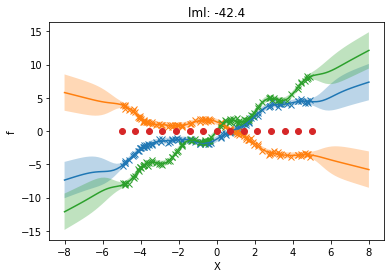

In [10]:
# Plot predictions and observations
plot_model(m)

In [11]:
print_summary(m.kernel)
m.kernel.kernel.kernels[0].lengthscale

name,class,transform,trainable,shape,dtype,value
SharedIndependent.kernel.Sum_kernels[0].variance,Parameter,Softplus,True,(),float64,0.927603
SharedIndependent.kernel.Sum_kernels[0].lengthscale,Parameter,Softplus,True,(),float64,0.798277
SharedIndependent.kernel.Sum_kernels[1].variance,Parameter,Softplus,True,(),float64,1.21377


<tf.Tensor: id=1615474, shape=(), dtype=float64, numpy=0.7982771183272557>

### 2. Separate Independent MOK & Shared Independent Inducing Variables
Here we allow different hyperparameters for the priors of each output. We still share the inducing inputs between all outputs.

In [12]:
# Create list of kernels for each output
kern_list = [gpf.kernels.RBF(D) + gpf.kernels.Linear(1) for _ in range(P)]
# Create multioutput kernel from kernel list
kernel = gpf.kernels.SeparateIndependent(kern_list)
# initialisation of inducing input locations (M random points from the training inputs)
Z = Zinit.copy() 
# create multioutput inducing variables from Z
iv = gpf.inducing_variables.SharedIndependentInducingVariables(gpf.inducing_variables.InducingPoints(Z))

In [13]:
# create SVGP model as usual and optimize
m = gpf.models.SVGP(kernel, gpf.likelihoods.Gaussian(), inducing_variables=iv, num_latent=P)

In [14]:
res = gpf.optimizers.Scipy().minimize(
    lambda: -m.log_likelihood(X, Y),
    variables=m.trainable_variables,
    method="l-bfgs-b",
    options={"disp": True, "maxiter": min(2500, MAXITER)}
)

In [15]:
print_summary(m.kernel)

name,class,transform,trainable,shape,dtype,value
SeparateIndependent.SeparateIndependent_kernels[0].Sum_kernels[0].variance,Parameter,Softplus,True,(),float64,0.86325
SeparateIndependent.SeparateIndependent_kernels[0].Sum_kernels[0].lengthscale,Parameter,Softplus,True,(),float64,0.93455
SeparateIndependent.SeparateIndependent_kernels[0].Sum_kernels[1].variance,Parameter,Softplus,True,(),float64,0.861936
SeparateIndependent.SeparateIndependent_kernels[1].Sum_kernels[0].variance,Parameter,Softplus,True,(),float64,0.750609
SeparateIndependent.SeparateIndependent_kernels[1].Sum_kernels[0].lengthscale,Parameter,Softplus,True,(),float64,0.969858
SeparateIndependent.SeparateIndependent_kernels[1].Sum_kernels[1].variance,Parameter,Softplus,True,(),float64,0.530452
SeparateIndependent.SeparateIndependent_kernels[2].Sum_kernels[0].variance,Parameter,Softplus,True,(),float64,1.11013
SeparateIndependent.SeparateIndependent_kernels[2].Sum_kernels[0].lengthscale,Parameter,Softplus,True,(),float64,0.748979
SeparateIndependent.SeparateIndependent_kernels[2].Sum_kernels[1].variance,Parameter,Softplus,True,(),float64,2.22189


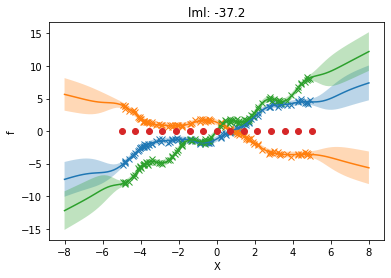

In [16]:
plot_model(m)

In [17]:
[k.kernels[0].lengthscale for k in m.kernel.kernels]

[<tf.Tensor: id=6179716, shape=(), dtype=float64, numpy=0.9345497974956555>,
 <tf.Tensor: id=6179719, shape=(), dtype=float64, numpy=0.9698576483396266>,
 <tf.Tensor: id=6179722, shape=(), dtype=float64, numpy=0.7489786661169335>]

### 3. Separate Independent Kernel & Separate Independent Inducing Variables
Here we allow different hyperparameters for the priors of each output. We now allow different inducing inputs for each output.

In [18]:
# Create list of kernels for each output
kern_list = [gpf.kernels.RBF(D) + gpf.kernels.Linear(1) for _ in range(P)]
# Create multioutput kernel from kernel list
kernel = gpf.kernels.SeparateIndependent(kern_list)
# initialisation of inducing input locations, one set of locations per output
Zs = [Zinit.copy() for _ in range(P)]
# initialise as list inducing inducing variables
iv_list = [gpf.inducing_variables.InducingPoints(Z) for Z in Zs]
# create multioutput inducing variables from iv_list
iv = gpf.inducing_variables.SeparateIndependentInducingVariables(iv_list)

**NOTE:** While the inducing points are independent, there needs to be the same number of inducing points per dimension.

In [19]:
# create SVGP model as usual and optimize
m = gpf.models.SVGP(kernel, gpf.likelihoods.Gaussian(), inducing_variables=iv, num_latent=P)

In [20]:
res = gpf.optimizers.Scipy().minimize(
    lambda: -m.log_likelihood(X, Y), 
    variables=m.trainable_variables,
    method="l-bfgs-b", 
    options={"disp": True, "maxiter": MAXITER}
)

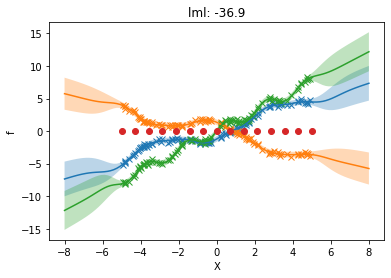

In [21]:
plot_model(m)

The plot below shows that we use different inducing *inputs* in each output dimension.

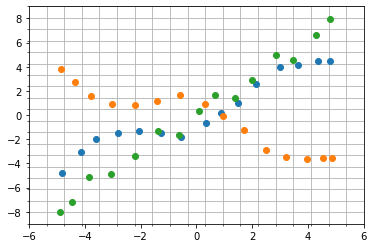

In [22]:
for i in range(len(m.inducing_variables.inducing_variable_list)):
    q_mu_unwhitened, q_var_unwhitened = m.predict_f(m.inducing_variables.inducing_variable_list[i].Z)
    plt.plot(m.inducing_variables.inducing_variable_list[i].Z.numpy(), q_mu_unwhitened[:, i, None].numpy(), "o")
plt.gca().set_xticks(np.linspace(-6, 6, 20), minor=True)
plt.gca().set_yticks(np.linspace(-9, 9, 20), minor=True)
plt.grid(which='minor')

In [23]:
m.inducing_variables.inducing_variable_list

ListWrapper([<gpflow.inducing_variables.inducing_variables.InducingPoints object at 0x1039653a10>, <gpflow.inducing_variables.inducing_variables.InducingPoints object at 0x10346e62d0>, <gpflow.inducing_variables.inducing_variables.InducingPoints object at 0x1031c826d0>])

## Modelling $f(x)$ by doing inference in the $g$ space
### Mixed Kernel & Uncorrelated Inducing Variables 

Remember the general case: $f(x) = W g(x)$, where $g(x) \in \mathbb{R}^L$, $f(x) \in \mathbb{R}^P$ and $W \in \mathbb{R}^{P \times L}$, where $L \leq P$.
We assume that the outputs of $g$ are uncorrelated, and by *mixing* them with $W$ they become correlated.
With this setup we perform the optimal routine to calculate the conditional. Namely, calculate the conditional of the uncorrelated latent $g$ and afterwards project the mean and variance using the mixing matrix: $\mu_f = W \mu_g$ and $\Sigma_f = W\Sigma_g W^\top$

- $ K_{uu} = L \times M \times M $
- $ K_{uf} = L \times M \times N $

In [24]:
# Create list of kernels for each output
kern_list = [gpf.kernels.RBF(D) + gpf.kernels.Linear(D) for _ in range(L)]
# Create multioutput kernel from kernel list
kernel = gpf.kernels.LinearCoregionalization(kern_list, W=np.random.randn(P, L)) # Notice that we initialise the mixing matrix W
# initialisation of inducing input locations (M random points from the training inputs)
Z = Zinit.copy()
# create multioutput inducing variables from Z
iv = gpf.inducing_variables.SharedIndependentInducingVariables(gpf.inducing_variables.InducingPoints(Z))

In [25]:
# initialise mean of variational posterior to be of shape MxL
q_mu = np.zeros((M, L)) 
# initialise \sqrt(Σ) of variational posterior to be of shape LxMxM
q_sqrt = np.repeat(np.eye(M)[None, ...], L, axis=0) * 1.0 

# create SVGP model as usual and optimize
m = gpf.models.SVGP(kernel, gpf.likelihoods.Gaussian(), inducing_variables=iv, q_mu=q_mu, q_sqrt=q_sqrt)

In [26]:
res = gpf.optimizers.Scipy().minimize(
    lambda: -m.log_likelihood(X, Y), 
    variables=m.trainable_variables,
    method="l-bfgs-b", 
    options={"disp": True, "maxiter": MAXITER}
)

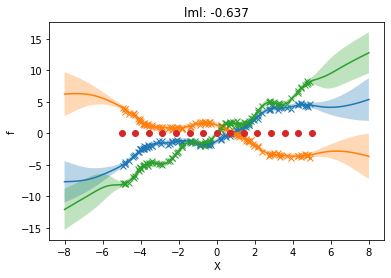

In [27]:
plot_model(m)

## Illustration of GPflow's Multioutput Capabilities
Below are illustration of the inheritance structure in GPflow's multioutput framework.

### Multi-output kernels (MOK) class diagram
We include three multioutput kernels:
- `SharedIndependent`: This kernel is included mainly as an illustration of specifying a conditional using the multiple dispatch framework. The same functionality is provided by using a normal kernel and passing in multiple approximate posteriors by stacking `q_mu` and `q_sqrt`.
- `SeparateIndepednent`: This allows different priors to be used for each output GP.
- `LinearCoregionalization`: A kernel describing the prior of the linear model of coregionalisation. As shown above, this implementation supports various inducing point approximations.
![Multioutput kernels](./multioutput_kernels.svg)

We include several base classes. Two are noteworthy:
- `MultioutputKernel` is included to be the base class for all multioutput kernels.
- `IndepedentLatent` is the base class for all multioutput kernels which are constructed from independent latent processes. Including this allows the specification of a default approximation method which, while not the most efficient, does take advantage of _some_ structure. And it can be applied to _any_ kernel constructed from independent latent processes.

There is a similarity in the meaning of `SeparateIndependent` and `IndependentLatent`. Both kernels indicate that independent processes are used, and that $\mathbf{K}_{\bf uu}$ can therefore be represented as a `[L, M, M]` tensor. It could therefore be suggested that `SeparateIndependent` be the parent class of all "independent latent" kernels, instead of having a separate `IndependentLatent` class. We decided against this because:
- this would increase the complexity in specifying `conditionals()` for the otherwise simple multioutput kernels `SeparateIndependent` and `SharedIndependent`.
- we did not want to specify too much of an implementation in `IndependentLatent`, leaving implementation details to child classes. Using `SeparateIndependent` as the base class would force all child classes to be a `Combination` kernel.

### Multioutput inducing variables class diagram
![Multioutput features](./multioutput_features.svg)

#### Inducing points
The goal of this class is to provide inducing variables that can be used with _any_ kernel, even if the method ends up being slow.

The multiouput framework extends `InducingPoints` to work with multioutput kernels. Just like for single-output kernels, we want `InducingPoints` to work for all `MultioutputKernel`s. We do this by defining `InducingPoints` to take _all_ outputs for given inducing inputs as inducing variables.

#### Fallback shared/separate independent inducing variables
The goal of these classes is to provide a reasonably efficient implementation for kernels that give exploitable independence strucutre in the prior of inducing variables (i.e. subclasses of `IndependentLatent`), while only needing to implement `Kuu()` and `Kuf()` methods.

#### Shared/separate independent inducing variables
The goal of these classes is to provide the most efficient code path for kernels that allow exploiting independence structure in the prior of inducing variables.

For more specialised multioutput kernels (i.e. `{Shared|Separate}Independent` or `LinearCoregionalization`) we define `{Shared|Separate}IndependentInducingVariables`. These wrap (a list of) single-output inducing variables to define groups of a-priori independent inducing variables, which leads to a $\mathbf{K}_{\bf uu}$ that can be represented as a `[L, M, M]` tensor. We saw the use of these above.

`{Shared|Separate}IndependentInducingVariables` inherit from `Fallback{Shared|Separate}IndependentInducingVariables`, so the multiple dispatch will fall back on the slower but general implementation.

### Implemented combinations
Multiple dispatch is applied to both `Kuu()`, `Kuf()`, and `conditional()`. The return values of the covariances can therefore be tailored to a specific implementation of `conditional()`. Below, we list combinations which are currently available in GPflow. Thanks to the multiple dispatch code, implementing your own outside of GPflow should require only a small amount of code!

| Inducing variable class                                      | Kernel                  | Kuu           | Kuf           | conditional                         | note                                                                                                                                                                                                                                                                                           |
|----------------------------------------------|-------------------------|---------------|---------------|-------------------------------------|------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|
| `InducingPoints`                               | `MultioutputKernel`       | `[M, P, M, P]` | `[M, P, N, P]` | `inducing_point_conditional()`, which calls `fully_correlated_conditional()`       | Works for all kernels, but may be very inefficient. In this case `q_mu` and `q_sqrt` should have shapes of `[1, MP]` and `[1, MP, MP]`  |
| `SharedIndependentInducingVariables`           | `SharedIndependent`       | `[M, M]`         | `[M, N]`         | `shared_independent_conditional()`, which calls `base_conditional()`                    | These combination of these two classes are in a sense redundant, because we can achieve the same behaviour by using the single output Kernel and InducingVariable classes. They are added for illustrative purposes. Thanks to the conditional dispatch, the most efficient code path is used. |
| `SeparateIndependentInducingVariables`         | `SharedIndependent`       | `[P, M, M]`     | `[P, M, N]`     | `separate_independent_conditional()`, which calls `base_conditional()` P times               | We loop P times over the `base_conditional()`         |
| `SeparateIndependentInducingVariable`         | `SeparateIndependent`     | `[P, M, M]`     | `[P, M, N]`     |  `separate_independent_conditional()`, which calls `base_conditional()` P times                | We loop P times over the `base_conditional()`           |
| `SharedIndependentInducingVariables`           | `SeparateIndependent`     | `[P, M, M]`     | `[P, M, N]`     | `separate_independent_conditional()`, which calls `base_conditional()` P times                | We loop P times over the `base_conditional()`        |
| `FallbackSharedIndependentInducingVariables`   | `IndependentLatent`       | `[L, M, M]`     | `[M, L, N, P]` | `fallback_independent_latent_conditional()`, which calls `independent_interdomain_conditional()` | Implementation which only requires custom `Kuu()` and `Kuf()` |
| `FallbackSeparateIndependentInducingVariable` | `IndependentLatent`       | `[L, M, M]`     | `[M, L, N, P]` | `fallback_independent_latent_conditional()`, which calls `independent_interdomain_conditional()` | Implementation which only requires custom `Kuu()` and `Kuf()`  |
| `SharedIndependentInducingVariables`           | `LinearCoregionalization` | `[L, M, M]`     | `[L, M, N]`     | `coregionalization_conditional()`, which calls `base_conditional()`                    | This is the most efficient implementation for Linear Coregionalisation.  The inducing outputs live in g-space. Here we use the output of the base conditional and project the mean and covariance with the mixing matrix W.                                                                    |
| `SeparateIndependentInducingVariables`         | `LinearCoregionalization` | `[L, M, M]`     | `[L, M, N]`     | base_conditional                    | This is the most efficient implementation for Linear Coregionalisation.  The inducing outputs live in g-space. Here we use the output of the base conditional and project the mean and covariance with the mixing matrix W.                                                                    |

## Further Reading:
- [Coregionalisation](./coregionalisation.ipynb), which details other GPflow features for multi-output prediction without fully observed outputs.